In [1]:
import os
import json
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from io import StringIO
load_dotenv()

True

In [2]:
plt.rcParams.update({
    "figure.figsize": (16, 10),
    "figure.dpi": 350,              # high-res by default
    "savefig.dpi": 400,             # even higher-res when saving
    "axes.grid": True,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
})


### definition of Areas and professions

In [ ]:
CLEVELAND_MSA_CODE = "17460"
TOP_50_METROS = {
    "35620": "New York-Newark-Jersey City, NY-NJ-PA",
    "31080": "Los Angeles-Long Beach-Anaheim, CA",
    "16980": "Chicago-Naperville-Elgin, IL-IN-WI",
    "19100": "Dallas-Fort Worth-Arlington, TX",
    "26420": "Houston-The Woodlands-Sugar Land, TX",
    "47900": "Washington-Arlington-Alexandria, DC-VA-MD-WV",
    "37980": "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",
    "33100": "Miami-Fort Lauderdale-West Palm Beach, FL",
    "12060": "Atlanta-Sandy Springs-Roswell, GA",
    "14460": "Boston-Cambridge-Newton, MA-NH",
    "38060": "Phoenix-Mesa-Scottsdale, AZ",
    "41740": "San Diego-Carlsbad, CA",
    "40140": "Riverside-San Bernardino-Ontario, CA",
    "33460": "Minneapolis-St. Paul-Bloomington, MN-WI",
    "45300": "Tampa-St. Petersburg-Clearwater, FL",
    "19740": "Denver-Aurora-Lakewood, CO",
    "41860": "San Francisco-Oakland-Hayward, CA",
    "42660": "Seattle-Tacoma-Bellevue, WA",
    "19820": "Detroit-Warren-Dearborn, MI",
    "41180": "St. Louis, MO-IL",
    "12420": "Austin-Round Rock, TX",
    "28140": "Kansas City, MO-KS",
    "17460": "Cleveland-Elyria, OH",
    "36740": "Orlando-Kissimmee-Sanford, FL",
    "41940": "San Jose-Sunnyvale-Santa Clara, CA",
    "38900": "Portland-Vancouver-Hillsboro, OR-WA",
    "40900": "Sacramento--Roseville--Arden-Arcade, CA",
    "17140": "Cincinnati, OH-KY-IN",
    "29820": "Las Vegas-Henderson-Paradise, NV",
    "18140": "Columbus, OH",
    "32820": "Memphis, TN-MS-AR",
    "14860": "Bridgeport-Stamford-Norwalk, CT",
    "16740": "Charlotte-Concord-Gastonia, NC-SC",
    "27260": "Jacksonville, FL",
    "35380": "New Orleans-Metairie, LA",
    "34980": "Nashville-Davidson--Murfreesboro--Franklin, TN",
    "39580": "Raleigh, NC",
    "40060": "Richmond, VA",
    "38300": "Pittsburgh, PA",
    "15380": "Buffalo-Cheektowaga-Niagara Falls, NY",
    "39300": "Providence-Warwick, RI-MA",
    "36420": "Oklahoma City, OK",
    "23420": "Fresno, CA",
    "13820": "Birmingham-Hoover, AL",
    "40380": "Rochester, NY",
    "26900": "Indianapolis-Carmel-Anderson, IN",
    "41620": "Salt Lake City, UT",
    "17820": "Colorado Springs, CO",
    "25540": "Hartford-West Hartford-East Hartford, CT",
    "13380": "Baton Rouge, LA"
}

# Advanced manufacturing NAICS codes we care about
ADV_MFG_NAICS = {
    "3251": "Basic Chemical Manufacturing",
    "3254": "Pharmaceutical & Medicine Manufacturing",
    "3332": "Industrial Machinery Manufacturing",
    "3339": "Other General-Purpose Machinery Manufacturing",
    "3344": "Semiconductor & Other Electronic Component Mfg",
    "3345": "Navigational, Electromedical, & Control Instruments",
    "3359": "Other Electrical Equipment & Component Mfg (incl batteries)",
    "3361": "Motor Vehicle Manufacturing",
    "3362": "Motor Vehicle Body & Trailer Manufacturing",
    "3363": "Motor Vehicle Parts Manufacturing",
    "3364": "Aerospace Product & Parts Manufacturing",
    "3391": "Medical Equipment & Supplies Manufacturing"
}

BIOMED_TECH_NAICS = {
    "3254": "Pharmaceutical & Medicine Manufacturing",
    "3391": "Medical Equipment & Supplies Manufacturing",
    "5417": "Scientific Research & Development Services",
    "6215": "Medical & Diagnostic Laboratories",
    "6221": "General Medical & Surgical Hospitals",
    "3345": "Electromedical & Control Instruments (medical devices, imaging)",
}
CONVENTIONAL_TECH_NAICS = {
    "5112": "Software Publishers",
    "5182": "Data Processing, Hosting & Cloud Services",
    "5191": "Other Information Services (incl search engines)",
    "5415": "Computer Systems Design & Related Services",
    "5416": "Management, Scientific & Technical Consulting (tech-heavy)",
    "5173": "Wired & Wireless Telecommunications Carriers",
    "5179": "Other Telecommunications (data networks)",
    "3341": "Computer & Peripheral Equipment Manufacturing",
    "3342": "Communications Equipment Manufacturing",
}

FINANCE_NAICS = {
    "52":   "Finance & Insurance (supersector)",
    "521":  "Monetary Authorities & Central Banking",
    "5221": "Depository Credit Intermediation (Banks)",
    "5222": "Nondepository Credit (Lending, Mortgage)",
    "5231": "Securities & Investment Firms",
    "5232": "Securities Brokers & Exchanges",
    "5239": "Other Financial Investment Activities",
    "5241": "Insurance Carriers",
    "5242": "Insurance Agencies & Brokerages",
}

BLUE_COLLAR_NAICS = {
    "23":   "Construction (all types)",
    "31":   "Manufacturing (Food, Textiles, Plastics, etc.)",
    "32":   "Manufacturing (Fabrics, Wood, Paper, Printing)",
    "33":   "Manufacturing (Machinery, Metals, Appliances)",
    "48":   "Transportation (truck, rail, air)",
    "49":   "Warehousing & Logistics",
    "221":  "Utilities (electric, water, gas)",
    "811":  "Repair & Maintenance (auto, HVAC, machinery)",
}

years = list(range(2015,2024))


In [4]:
COL_DATA = {
    "New York-Newark-Jersey City, NY-NJ-PA": 148,
    "Los Angeles-Long Beach-Anaheim, CA": 145,
    "Chicago-Naperville-Elgin, IL-IN-WI": 108,
    "Dallas-Fort Worth-Arlington, TX": 98,
    "Houston-The Woodlands-Sugar Land, TX": 92,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 142,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 120,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 118,
    "Atlanta-Sandy Springs-Roswell, GA": 102,
    "Boston-Cambridge-Newton, MA-NH": 140,
    "Phoenix-Mesa-Scottsdale, AZ": 103,
    "San Diego-Carlsbad, CA": 150,
    "Riverside-San Bernardino-Ontario, CA": 122,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 108,
    "Tampa-St. Petersburg-Clearwater, FL": 98,
    "Denver-Aurora-Lakewood, CO": 120,
    "San Francisco-Oakland-Hayward, CA": 165,
    "Seattle-Tacoma-Bellevue, WA": 135,
    "Detroit-Warren-Dearborn, MI": 90,
    "St. Louis, MO-IL": 88,
    "Austin-Round Rock, TX": 108,
    "Kansas City, MO-KS": 90,
    "Cleveland-Elyria, OH": 88,
    "Orlando-Kissimmee-Sanford, FL": 100,
    "San Jose-Sunnyvale-Santa Clara, CA": 172,
    "Portland-Vancouver-Hillsboro, OR-WA": 125,
    "Sacramento--Roseville--Arden-Arcade, CA": 128,
    "Cincinnati, OH-KY-IN": 92,
    "Las Vegas-Henderson-Paradise, NV": 105,
    "Columbus, OH": 93,
    "Memphis, TN-MS-AR": 85,
    "Bridgeport-Stamford-Norwalk, CT": 145,
    "Charlotte-Concord-Gastonia, NC-SC": 98,
    "Jacksonville, FL": 95,
    "New Orleans-Metairie, LA": 95,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 103,
    "Raleigh, NC": 102,
    "Richmond, VA": 98,
    "Pittsburgh, PA": 95,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 90,
    "Providence-Warwick, RI-MA": 115,
    "Oklahoma City, OK": 88,
    "Fresno, CA": 105,
    "Birmingham-Hoover, AL": 87,
    "Rochester, NY": 92,
    "Indianapolis-Carmel-Anderson, IN": 92,
    "Salt Lake City, UT": 110,
    "Colorado Springs, CO": 105,
    "Hartford-West Hartford-East Hartford, CT": 120,
    "Baton Rouge, LA": 90
}

# Median Rent Data (1-bedroom, city center estimates)
RENT_DATA = {
    "New York-Newark-Jersey City, NY-NJ-PA": 2800,
    "Los Angeles-Long Beach-Anaheim, CA": 2100,
    "Chicago-Naperville-Elgin, IL-IN-WI": 1500,
    "Dallas-Fort Worth-Arlington, TX": 1300,
    "Houston-The Woodlands-Sugar Land, TX": 1200,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 2200,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 1600,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 1800,
    "Atlanta-Sandy Springs-Roswell, GA": 1400,
    "Boston-Cambridge-Newton, MA-NH": 2300,
    "Phoenix-Mesa-Scottsdale, AZ": 1300,
    "San Diego-Carlsbad, CA": 2400,
    "Riverside-San Bernardino-Ontario, CA": 1500,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 1400,
    "Tampa-St. Petersburg-Clearwater, FL": 1300,
    "Denver-Aurora-Lakewood, CO": 1600,
    "San Francisco-Oakland-Hayward, CA": 3200,
    "Seattle-Tacoma-Bellevue, WA": 2100,
    "Detroit-Warren-Dearborn, MI": 1000,
    "St. Louis, MO-IL": 950,
    "Austin-Round Rock, TX": 1400,
    "Kansas City, MO-KS": 1000,
    "Cleveland-Elyria, OH": 950,
    "Orlando-Kissimmee-Sanford, FL": 1350,
    "San Jose-Sunnyvale-Santa Clara, CA": 3400,
    "Portland-Vancouver-Hillsboro, OR-WA": 1700,
    "Sacramento--Roseville--Arden-Arcade, CA": 1600,
    "Cincinnati, OH-KY-IN": 1000,
    "Las Vegas-Henderson-Paradise, NV": 1250,
    "Columbus, OH": 1050,
    "Memphis, TN-MS-AR": 900,
    "Bridgeport-Stamford-Norwalk, CT": 2100,
    "Charlotte-Concord-Gastonia, NC-SC": 1250,
    "Jacksonville, FL": 1200,
    "New Orleans-Metairie, LA": 1150,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 1450,
    "Raleigh, NC": 1300,
    "Richmond, VA": 1150,
    "Pittsburgh, PA": 1050,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 950,
    "Providence-Warwick, RI-MA": 1400,
    "Oklahoma City, OK": 900,
    "Fresno, CA": 1100,
    "Birmingham-Hoover, AL": 900,
    "Rochester, NY": 950,
    "Indianapolis-Carmel-Anderson, IN": 1000,
    "Salt Lake City, UT": 1350,
    "Colorado Springs, CO": 1200,
    "Hartford-West Hartford-East Hartford, CT": 1500,
    "Baton Rouge, LA": 950
}

# Engineering Salary Data (median from BLS OEWS - estimates)
ENGINEERING_SALARY = {
    "New York-Newark-Jersey City, NY-NJ-PA": 118000,
    "Los Angeles-Long Beach-Anaheim, CA": 110000,
    "Chicago-Naperville-Elgin, IL-IN-WI": 92000,
    "Dallas-Fort Worth-Arlington, TX": 95000,
    "Houston-The Woodlands-Sugar Land, TX": 105000,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 115000,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 98000,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 88000,
    "Atlanta-Sandy Springs-Roswell, GA": 90000,
    "Boston-Cambridge-Newton, MA-NH": 110000,
    "Phoenix-Mesa-Scottsdale, AZ": 88000,
    "San Diego-Carlsbad, CA": 108000,
    "Riverside-San Bernardino-Ontario, CA": 92000,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 92000,
    "Tampa-St. Petersburg-Clearwater, FL": 82000,
    "Denver-Aurora-Lakewood, CO": 98000,
    "San Francisco-Oakland-Hayward, CA": 135000,
    "Seattle-Tacoma-Bellevue, WA": 122000,
    "Detroit-Warren-Dearborn, MI": 88000,
    "St. Louis, MO-IL": 82000,
    "Austin-Round Rock, TX": 95000,
    "Kansas City, MO-KS": 85000,
    "Cleveland-Elyria, OH": 78000,
    "Orlando-Kissimmee-Sanford, FL": 80000,
    "San Jose-Sunnyvale-Santa Clara, CA": 140000,
    "Portland-Vancouver-Hillsboro, OR-WA": 100000,
    "Sacramento--Roseville--Arden-Arcade, CA": 98000,
    "Cincinnati, OH-KY-IN": 80000,
    "Las Vegas-Henderson-Paradise, NV": 85000,
    "Columbus, OH": 82000,
    "Memphis, TN-MS-AR": 78000,
    "Bridgeport-Stamford-Norwalk, CT": 105000,
    "Charlotte-Concord-Gastonia, NC-SC": 88000,
    "Jacksonville, FL": 82000,
    "New Orleans-Metairie, LA": 85000,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 87000,
    "Raleigh, NC": 90000,
    "Richmond, VA": 85000,
    "Pittsburgh, PA": 80000,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 75000,
    "Providence-Warwick, RI-MA": 88000,
    "Oklahoma City, OK": 82000,
    "Fresno, CA": 80000,
    "Birmingham-Hoover, AL": 78000,
    "Rochester, NY": 80000,
    "Indianapolis-Carmel-Anderson, IN": 82000,
    "Salt Lake City, UT": 88000,
    "Colorado Springs, CO": 85000,
    "Hartford-West Hartford-East Hartford, CT": 95000,
    "Baton Rouge, LA": 85000
}

# 2. BIOMEDICAL ENGINEERS (BLS 17-2031)
BIOMED_ENGINEER_SALARY = {
    "New York-Newark-Jersey City, NY-NJ-PA": 108000,
    "Los Angeles-Long Beach-Anaheim, CA": 102000,
    "Chicago-Naperville-Elgin, IL-IN-WI": 87000,
    "Dallas-Fort Worth-Arlington, TX": 88000,
    "Houston-The Woodlands-Sugar Land, TX": 92000,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 105000,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 95000,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 82000,
    "Atlanta-Sandy Springs-Roswell, GA": 85000,
    "Boston-Cambridge-Newton, MA-NH": 105000,
    "Phoenix-Mesa-Scottsdale, AZ": 83000,
    "San Diego-Carlsbad, CA": 98000,
    "Riverside-San Bernardino-Ontario, CA": 85000,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 88000,
    "Tampa-St. Petersburg-Clearwater, FL": 78000,
    "Denver-Aurora-Lakewood, CO": 92000,
    "San Francisco-Oakland-Hayward, CA": 125000,
    "Seattle-Tacoma-Bellevue, WA": 112000,
    "Detroit-Warren-Dearborn, MI": 82000,
    "St. Louis, MO-IL": 79000,
    "Austin-Round Rock, TX": 88000,
    "Kansas City, MO-KS": 80000,
    "Cleveland-Elyria, OH": 76000,
    "Orlando-Kissimmee-Sanford, FL": 75000,
    "San Jose-Sunnyvale-Santa Clara, CA": 128000,
    "Portland-Vancouver-Hillsboro, OR-WA": 93000,
    "Sacramento--Roseville--Arden-Arcade, CA": 90000,
    "Cincinnati, OH-KY-IN": 77000,
    "Las Vegas-Henderson-Paradise, NV": 80000,
    "Columbus, OH": 79000,
    "Memphis, TN-MS-AR": 74000,
    "Bridgeport-Stamford-Norwalk, CT": 98000,
    "Charlotte-Concord-Gastonia, NC-SC": 83000,
    "Jacksonville, FL": 77000,
    "New Orleans-Metairie, LA": 80000,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 82000,
    "Raleigh, NC": 86000,
    "Richmond, VA": 81000,
    "Pittsburgh, PA": 78000,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 72000,
    "Providence-Warwick, RI-MA": 84000,
    "Oklahoma City, OK": 76000,
    "Fresno, CA": 75000,
    "Birmingham-Hoover, AL": 74000,
    "Rochester, NY": 77000,
    "Indianapolis-Carmel-Anderson, IN": 78000,
    "Salt Lake City, UT": 83000,
    "Colorado Springs, CO": 80000,
    "Hartford-West Hartford-East Hartford, CT": 90000,
    "Baton Rouge, LA": 79000
}

# 3. BIOMEDICAL RESEARCHERS (BLS 19-1042 Medical Scientists)
BIOMED_RESEARCHER_SALARY = {
    "New York-Newark-Jersey City, NY-NJ-PA": 112000,
    "Los Angeles-Long Beach-Anaheim, CA": 108000,
    "Chicago-Naperville-Elgin, IL-IN-WI": 91000,
    "Dallas-Fort Worth-Arlington, TX": 90000,
    "Houston-The Woodlands-Sugar Land, TX": 95000,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 118000,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 98000,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 85000,
    "Atlanta-Sandy Springs-Roswell, GA": 88000,
    "Boston-Cambridge-Newton, MA-NH": 115000,
    "Phoenix-Mesa-Scottsdale, AZ": 85000,
    "San Diego-Carlsbad, CA": 105000,
    "Riverside-San Bernardino-Ontario, CA": 88000,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 92000,
    "Tampa-St. Petersburg-Clearwater, FL": 80000,
    "Denver-Aurora-Lakewood, CO": 95000,
    "San Francisco-Oakland-Hayward, CA": 128000,
    "Seattle-Tacoma-Bellevue, WA": 118000,
    "Detroit-Warren-Dearborn, MI": 85000,
    "St. Louis, MO-IL": 82000,
    "Austin-Round Rock, TX": 92000,
    "Kansas City, MO-KS": 83000,
    "Cleveland-Elyria, OH": 79000,
    "Orlando-Kissimmee-Sanford, FL": 78000,
    "San Jose-Sunnyvale-Santa Clara, CA": 132000,
    "Portland-Vancouver-Hillsboro, OR-WA": 96000,
    "Sacramento--Roseville--Arden-Arcade, CA": 93000,
    "Cincinnati, OH-KY-IN": 81000,
    "Las Vegas-Henderson-Paradise, NV": 82000,
    "Columbus, OH": 82000,
    "Memphis, TN-MS-AR": 76000,
    "Bridgeport-Stamford-Norwalk, CT": 102000,
    "Charlotte-Concord-Gastonia, NC-SC": 86000,
    "Jacksonville, FL": 80000,
    "New Orleans-Metairie, LA": 83000,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 85000,
    "Raleigh, NC": 89000,
    "Richmond, VA": 84000,
    "Pittsburgh, PA": 81000,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 74000,
    "Providence-Warwick, RI-MA": 87000,
    "Oklahoma City, OK": 79000,
    "Fresno, CA": 78000,
    "Birmingham-Hoover, AL": 76000,
    "Rochester, NY": 79000,
    "Indianapolis-Carmel-Anderson, IN": 81000,
    "Salt Lake City, UT": 86000,
    "Colorado Springs, CO": 82000,
    "Hartford-West Hartford-East Hartford, CT": 94000,
    "Baton Rouge, LA": 81000
}

# 4. TECH (Software Developers, Data Scientists)
TECH_SALARY = {
    "New York-Newark-Jersey City, NY-NJ-PA": 135000,
    "Los Angeles-Long Beach-Anaheim, CA": 125000,
    "Chicago-Naperville-Elgin, IL-IN-WI": 105000,
    "Dallas-Fort Worth-Arlington, TX": 108000,
    "Houston-The Woodlands-Sugar Land, TX": 110000,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 128000,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 112000,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 98000,
    "Atlanta-Sandy Springs-Roswell, GA": 105000,
    "Boston-Cambridge-Newton, MA-NH": 130000,
    "Phoenix-Mesa-Scottsdale, AZ": 102000,
    "San Diego-Carlsbad, CA": 122000,
    "Riverside-San Bernardino-Ontario, CA": 105000,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 108000,
    "Tampa-St. Petersburg-Clearwater, FL": 95000,
    "Denver-Aurora-Lakewood, CO": 115000,
    "San Francisco-Oakland-Hayward, CA": 165000,
    "Seattle-Tacoma-Bellevue, WA": 155000,
    "Detroit-Warren-Dearborn, MI": 98000,
    "St. Louis, MO-IL": 92000,
    "Austin-Round Rock, TX": 115000,
    "Kansas City, MO-KS": 95000,
    "Cleveland-Elyria, OH": 88000,
    "Orlando-Kissimmee-Sanford, FL": 92000,
    "San Jose-Sunnyvale-Santa Clara, CA": 175000,
    "Portland-Vancouver-Hillsboro, OR-WA": 118000,
    "Sacramento--Roseville--Arden-Arcade, CA": 110000,
    "Cincinnati, OH-KY-IN": 90000,
    "Las Vegas-Henderson-Paradise, NV": 95000,
    "Columbus, OH": 93000,
    "Memphis, TN-MS-AR": 85000,
    "Bridgeport-Stamford-Norwalk, CT": 125000,
    "Charlotte-Concord-Gastonia, NC-SC": 102000,
    "Jacksonville, FL": 90000,
    "New Orleans-Metairie, LA": 92000,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 100000,
    "Raleigh, NC": 108000,
    "Richmond, VA": 95000,
    "Pittsburgh, PA": 92000,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 82000,
    "Providence-Warwick, RI-MA": 100000,
    "Oklahoma City, OK": 88000,
    "Fresno, CA": 85000,
    "Birmingham-Hoover, AL": 83000,
    "Rochester, NY": 88000,
    "Indianapolis-Carmel-Anderson, IN": 92000,
    "Salt Lake City, UT": 105000,
    "Colorado Springs, CO": 95000,
    "Hartford-West Hartford-East Hartford, CT": 108000,
    "Baton Rouge, LA": 90000
}

# 5. FINANCE (Financial Analysts, Investment Professionals)
FINANCE_SALARY = {
    "New York-Newark-Jersey City, NY-NJ-PA": 145000,
    "Los Angeles-Long Beach-Anaheim, CA": 118000,
    "Chicago-Naperville-Elgin, IL-IN-WI": 105000,
    "Dallas-Fort Worth-Arlington, TX": 98000,
    "Houston-The Woodlands-Sugar Land, TX": 102000,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 125000,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 108000,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 95000,
    "Atlanta-Sandy Springs-Roswell, GA": 100000,
    "Boston-Cambridge-Newton, MA-NH": 122000,
    "Phoenix-Mesa-Scottsdale, AZ": 92000,
    "San Diego-Carlsbad, CA": 105000,
    "Riverside-San Bernardino-Ontario, CA": 90000,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 98000,
    "Tampa-St. Petersburg-Clearwater, FL": 88000,
    "Denver-Aurora-Lakewood, CO": 105000,
    "San Francisco-Oakland-Hayward, CA": 152000,
    "Seattle-Tacoma-Bellevue, WA": 128000,
    "Detroit-Warren-Dearborn, MI": 90000,
    "St. Louis, MO-IL": 85000,
    "Austin-Round Rock, TX": 102000,
    "Kansas City, MO-KS": 88000,
    "Cleveland-Elyria, OH": 82000,
    "Orlando-Kissimmee-Sanford, FL": 85000,
    "San Jose-Sunnyvale-Santa Clara, CA": 155000,
    "Portland-Vancouver-Hillsboro, OR-WA": 105000,
    "Sacramento--Roseville--Arden-Arcade, CA": 98000,
    "Cincinnati, OH-KY-IN": 86000,
    "Las Vegas-Henderson-Paradise, NV": 90000,
    "Columbus, OH": 88000,
    "Memphis, TN-MS-AR": 80000,
    "Bridgeport-Stamford-Norwalk, CT": 135000,
    "Charlotte-Concord-Gastonia, NC-SC": 98000,
    "Jacksonville, FL": 85000,
    "New Orleans-Metairie, LA": 88000,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 92000,
    "Raleigh, NC": 95000,
    "Richmond, VA": 90000,
    "Pittsburgh, PA": 88000,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 78000,
    "Providence-Warwick, RI-MA": 92000,
    "Oklahoma City, OK": 82000,
    "Fresno, CA": 80000,
    "Birmingham-Hoover, AL": 79000,
    "Rochester, NY": 83000,
    "Indianapolis-Carmel-Anderson, IN": 87000,
    "Salt Lake City, UT": 95000,
    "Colorado Springs, CO": 88000,
    "Hartford-West Hartford-East Hartford, CT": 110000,
    "Baton Rouge, LA": 85000
}

JOB_GROWTH_DATA = {
    "New York-Newark-Jersey City, NY-NJ-PA": 8.2,
    "Los Angeles-Long Beach-Anaheim, CA": 10.5,
    "Chicago-Naperville-Elgin, IL-IN-WI": 9.8,
    "Dallas-Fort Worth-Arlington, TX": 19.5,
    "Houston-The Woodlands-Sugar Land, TX": 15.2,
    "Washington-Arlington-Alexandria, DC-VA-MD-WV": 12.5,
    "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": 8.5,
    "Miami-Fort Lauderdale-West Palm Beach, FL": 13.8,
    "Atlanta-Sandy Springs-Roswell, GA": 17.2,
    "Boston-Cambridge-Newton, MA-NH": 12.5,
    "Phoenix-Mesa-Scottsdale, AZ": 18.5,
    "San Diego-Carlsbad, CA": 13.2,
    "Riverside-San Bernardino-Ontario, CA": 14.5,
    "Minneapolis-St. Paul-Bloomington, MN-WI": 11.5,
    "Tampa-St. Petersburg-Clearwater, FL": 15.8,
    "Denver-Aurora-Lakewood, CO": 17.8,
    "San Francisco-Oakland-Hayward, CA": 15.3,
    "Seattle-Tacoma-Bellevue, WA": 17.8,
    "Detroit-Warren-Dearborn, MI": 11.0,
    "St. Louis, MO-IL": 9.5,
    "Austin-Round Rock, TX": 22.0,
    "Kansas City, MO-KS": 12.5,
    "Cleveland-Elyria, OH": 18.5,
    "Orlando-Kissimmee-Sanford, FL": 16.2,
    "San Jose-Sunnyvale-Santa Clara, CA": 16.8,
    "Portland-Vancouver-Hillsboro, OR-WA": 15.5,
    "Sacramento--Roseville--Arden-Arcade, CA": 14.2,
    "Cincinnati, OH-KY-IN": 13.5,
    "Las Vegas-Henderson-Paradise, NV": 14.8,
    "Columbus, OH": 15.5,
    "Memphis, TN-MS-AR": 10.5,
    "Bridgeport-Stamford-Norwalk, CT": 7.8,
    "Charlotte-Concord-Gastonia, NC-SC": 18.2,
    "Jacksonville, FL": 14.5,
    "New Orleans-Metairie, LA": 9.8,
    "Nashville-Davidson--Murfreesboro--Franklin, TN": 19.5,
    "Raleigh, NC": 19.5,
    "Richmond, VA": 12.5,
    "Pittsburgh, PA": 14.2,
    "Buffalo-Cheektowaga-Niagara Falls, NY": 8.5,
    "Providence-Warwick, RI-MA": 9.2,
    "Oklahoma City, OK": 13.8,
    "Fresno, CA": 11.5,
    "Birmingham-Hoover, AL": 10.8,
    "Rochester, NY": 10.2,
    "Indianapolis-Carmel-Anderson, IN": 14.8,
    "Salt Lake City, UT": 18.5,
    "Colorado Springs, CO": 16.5,
    "Hartford-West Hartford-East Hartford, CT": 8.8,
    "Baton Rouge, LA": 9.5
}

# Job Growth by Field
JOB_GROWTH_ENGINEERING = {m: JOB_GROWTH_DATA[m] for m in COL_DATA.keys()}
JOB_GROWTH_BIOMED = {m: max(JOB_GROWTH_DATA[m] - 2, 8) if 'Boston' in m or 'San Francisco' in m or 'San Diego' in m or 'Raleigh' in m or 'Cleveland' in m else max(JOB_GROWTH_DATA[m] - 4, 5) for m in COL_DATA.keys()}
JOB_GROWTH_TECH = {m: JOB_GROWTH_DATA[m] + 3 if 'Austin' in m or 'Seattle' in m or 'San Jose' in m else JOB_GROWTH_DATA[m] + 1 for m in COL_DATA.keys()}
JOB_GROWTH_FINANCE = {m: max(JOB_GROWTH_DATA[m] - 5, 3) if 'New York' in m or 'Boston' in m or 'Chicago' in m else max(JOB_GROWTH_DATA[m] - 3, 4) for m in COL_DATA.keys()}


# create a master dataframe

metros = list(COL_DATA.keys())

# Create base dataframe
master_df = pd.DataFrame({
    'Metro': metros,
    'COL_Index': [COL_DATA[m] for m in metros],
    'Median_Rent': [RENT_DATA[m] for m in metros],
})

# Add salary data for each profession
professions = {
    'Engineering': ENGINEERING_SALARY,
    'Biomed_Engineer': BIOMED_ENGINEER_SALARY,
    'Biomed_Researcher': BIOMED_RESEARCHER_SALARY,
    'Tech': TECH_SALARY,
    'Finance': FINANCE_SALARY
}

for prof_name, salary_dict in professions.items():
    master_df[f'{prof_name}_Salary'] = [salary_dict[m] for m in metros]
    master_df[f'{prof_name}_Real_Salary'] = (master_df[f'{prof_name}_Salary'] / master_df['COL_Index']) * 100
    master_df[f'{prof_name}_Monthly_Salary'] = master_df[f'{prof_name}_Salary'] / 12
    master_df[f'{prof_name}_Housing_Burden'] = (master_df['Median_Rent'] / master_df[f'{prof_name}_Monthly_Salary']) * 100
    master_df[f'{prof_name}_Salary_Efficiency'] = master_df[f'{prof_name}_Salary'] / master_df['COL_Index']

# Add job growth
master_df['Job_Growth_Engineering'] = [JOB_GROWTH_DATA[m] for m in metros]
master_df['Job_Growth_Biomed'] = [max(JOB_GROWTH_DATA[m] - 2, 8) if any(x in m for x in ['Boston', 'San Francisco', 'San Diego', 'Raleigh', 'Cleveland', 'Pittsburgh']) else max(JOB_GROWTH_DATA[m] - 4, 5) for m in metros]
master_df['Job_Growth_Tech'] = [JOB_GROWTH_DATA[m] + 3 if any(x in m for x in ['Austin', 'Seattle', 'San Jose']) else JOB_GROWTH_DATA[m] + 1 for m in metros]
master_df['Job_Growth_Finance'] = [max(JOB_GROWTH_DATA[m] - 5, 3) if any(x in m for x in ['New York', 'Boston', 'Chicago']) else max(JOB_GROWTH_DATA[m] - 3, 4) for m in metros]

# Calculate derived metrics
master_df['Real_Salary'] = (master_df['Engineering_Salary'] / master_df['COL_Index']) * 100
master_df['Monthly_Salary'] = master_df['Engineering_Salary'] / 12
master_df['Housing_Burden_Pct'] = (master_df['Median_Rent'] / master_df['Monthly_Salary']) * 100
master_df['Salary_Efficiency'] = master_df['Engineering_Salary'] / master_df['COL_Index']

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure combined biomedical salary column exists ---
if 'Biomed_Combined_Salary' not in master_df.columns:
    master_df['Biomed_Combined_Salary'] = (
        master_df['Biomed_Engineer_Salary'] + master_df['Biomed_Researcher_Salary']
    ) / 2

# Professions we will compare
professions_for_plots = {
    'Tech': 'Tech_Salary',
    'Biomedical (Avg)': 'Biomed_Combined_Salary',
    'Engineering': 'Engineering_Salary',
    'Finance': 'Finance_Salary'
}

# Fixed list of comparison metros (Cleveland + peer hubs)
comparison_metros = [
    'Cleveland-Elyria, OH',
    'Pittsburgh, PA',
    'Columbus, OH',
    'Austin-Round Rock, TX',
    'Boston-Cambridge-Newton, MA-NH',
    'Seattle-Tacoma-Bellevue, WA',
    'San Francisco-Oakland-Hayward, CA',
    'New York-Newark-Jersey City, NY-NJ-PA'
]

# Subset in a stable order
subset = (
    master_df
    .set_index('Metro')
    .loc[comparison_metros]
    .reset_index()
)

cleveland_metro = 'Cleveland-Elyria, OH'

# Color palette per profession (consistent across all three plots)
prof_colors = {
    'Tech': '#F38181',
    'Biomedical (Avg)': '#4ECDC4',
    'Engineering': '#FF6B35',
    'Finance': '#AA96DA'
}

plt.rcParams.update({
    "figure.figsize": (16, 10),
    "figure.dpi": 350,
    "savefig.dpi": 400,
    "axes.grid": True,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
})


## visualization 1: salary efficiency

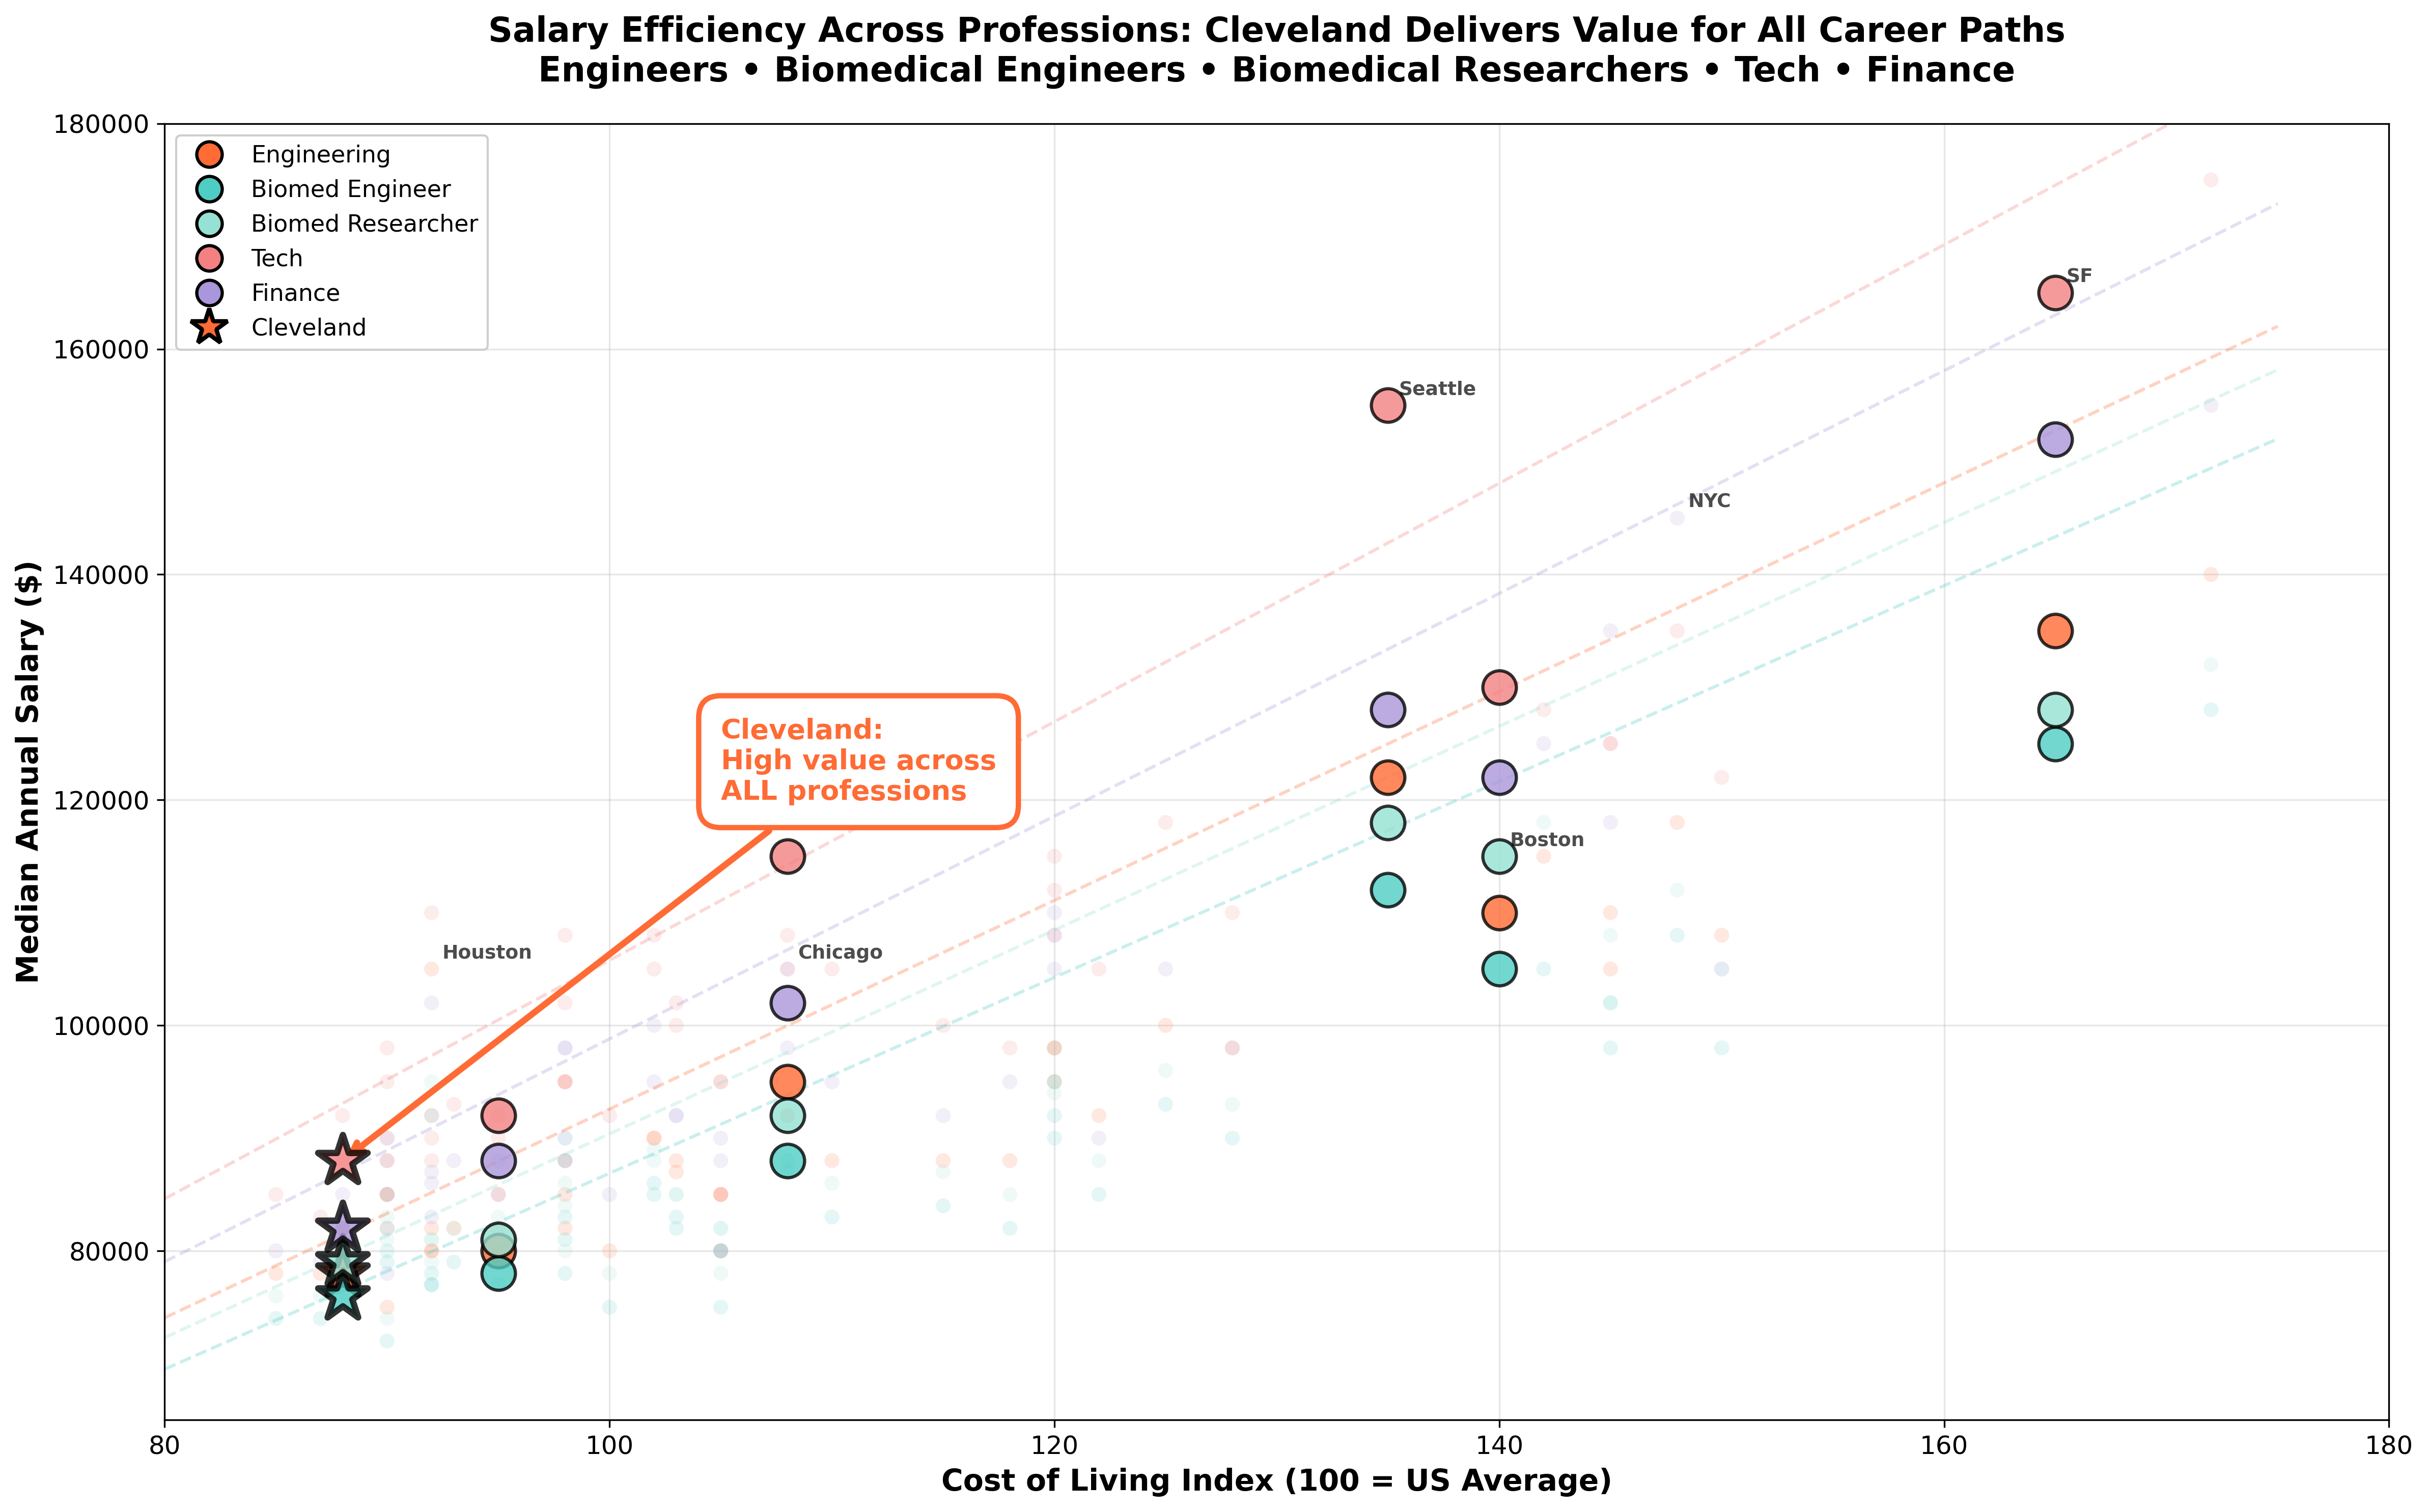

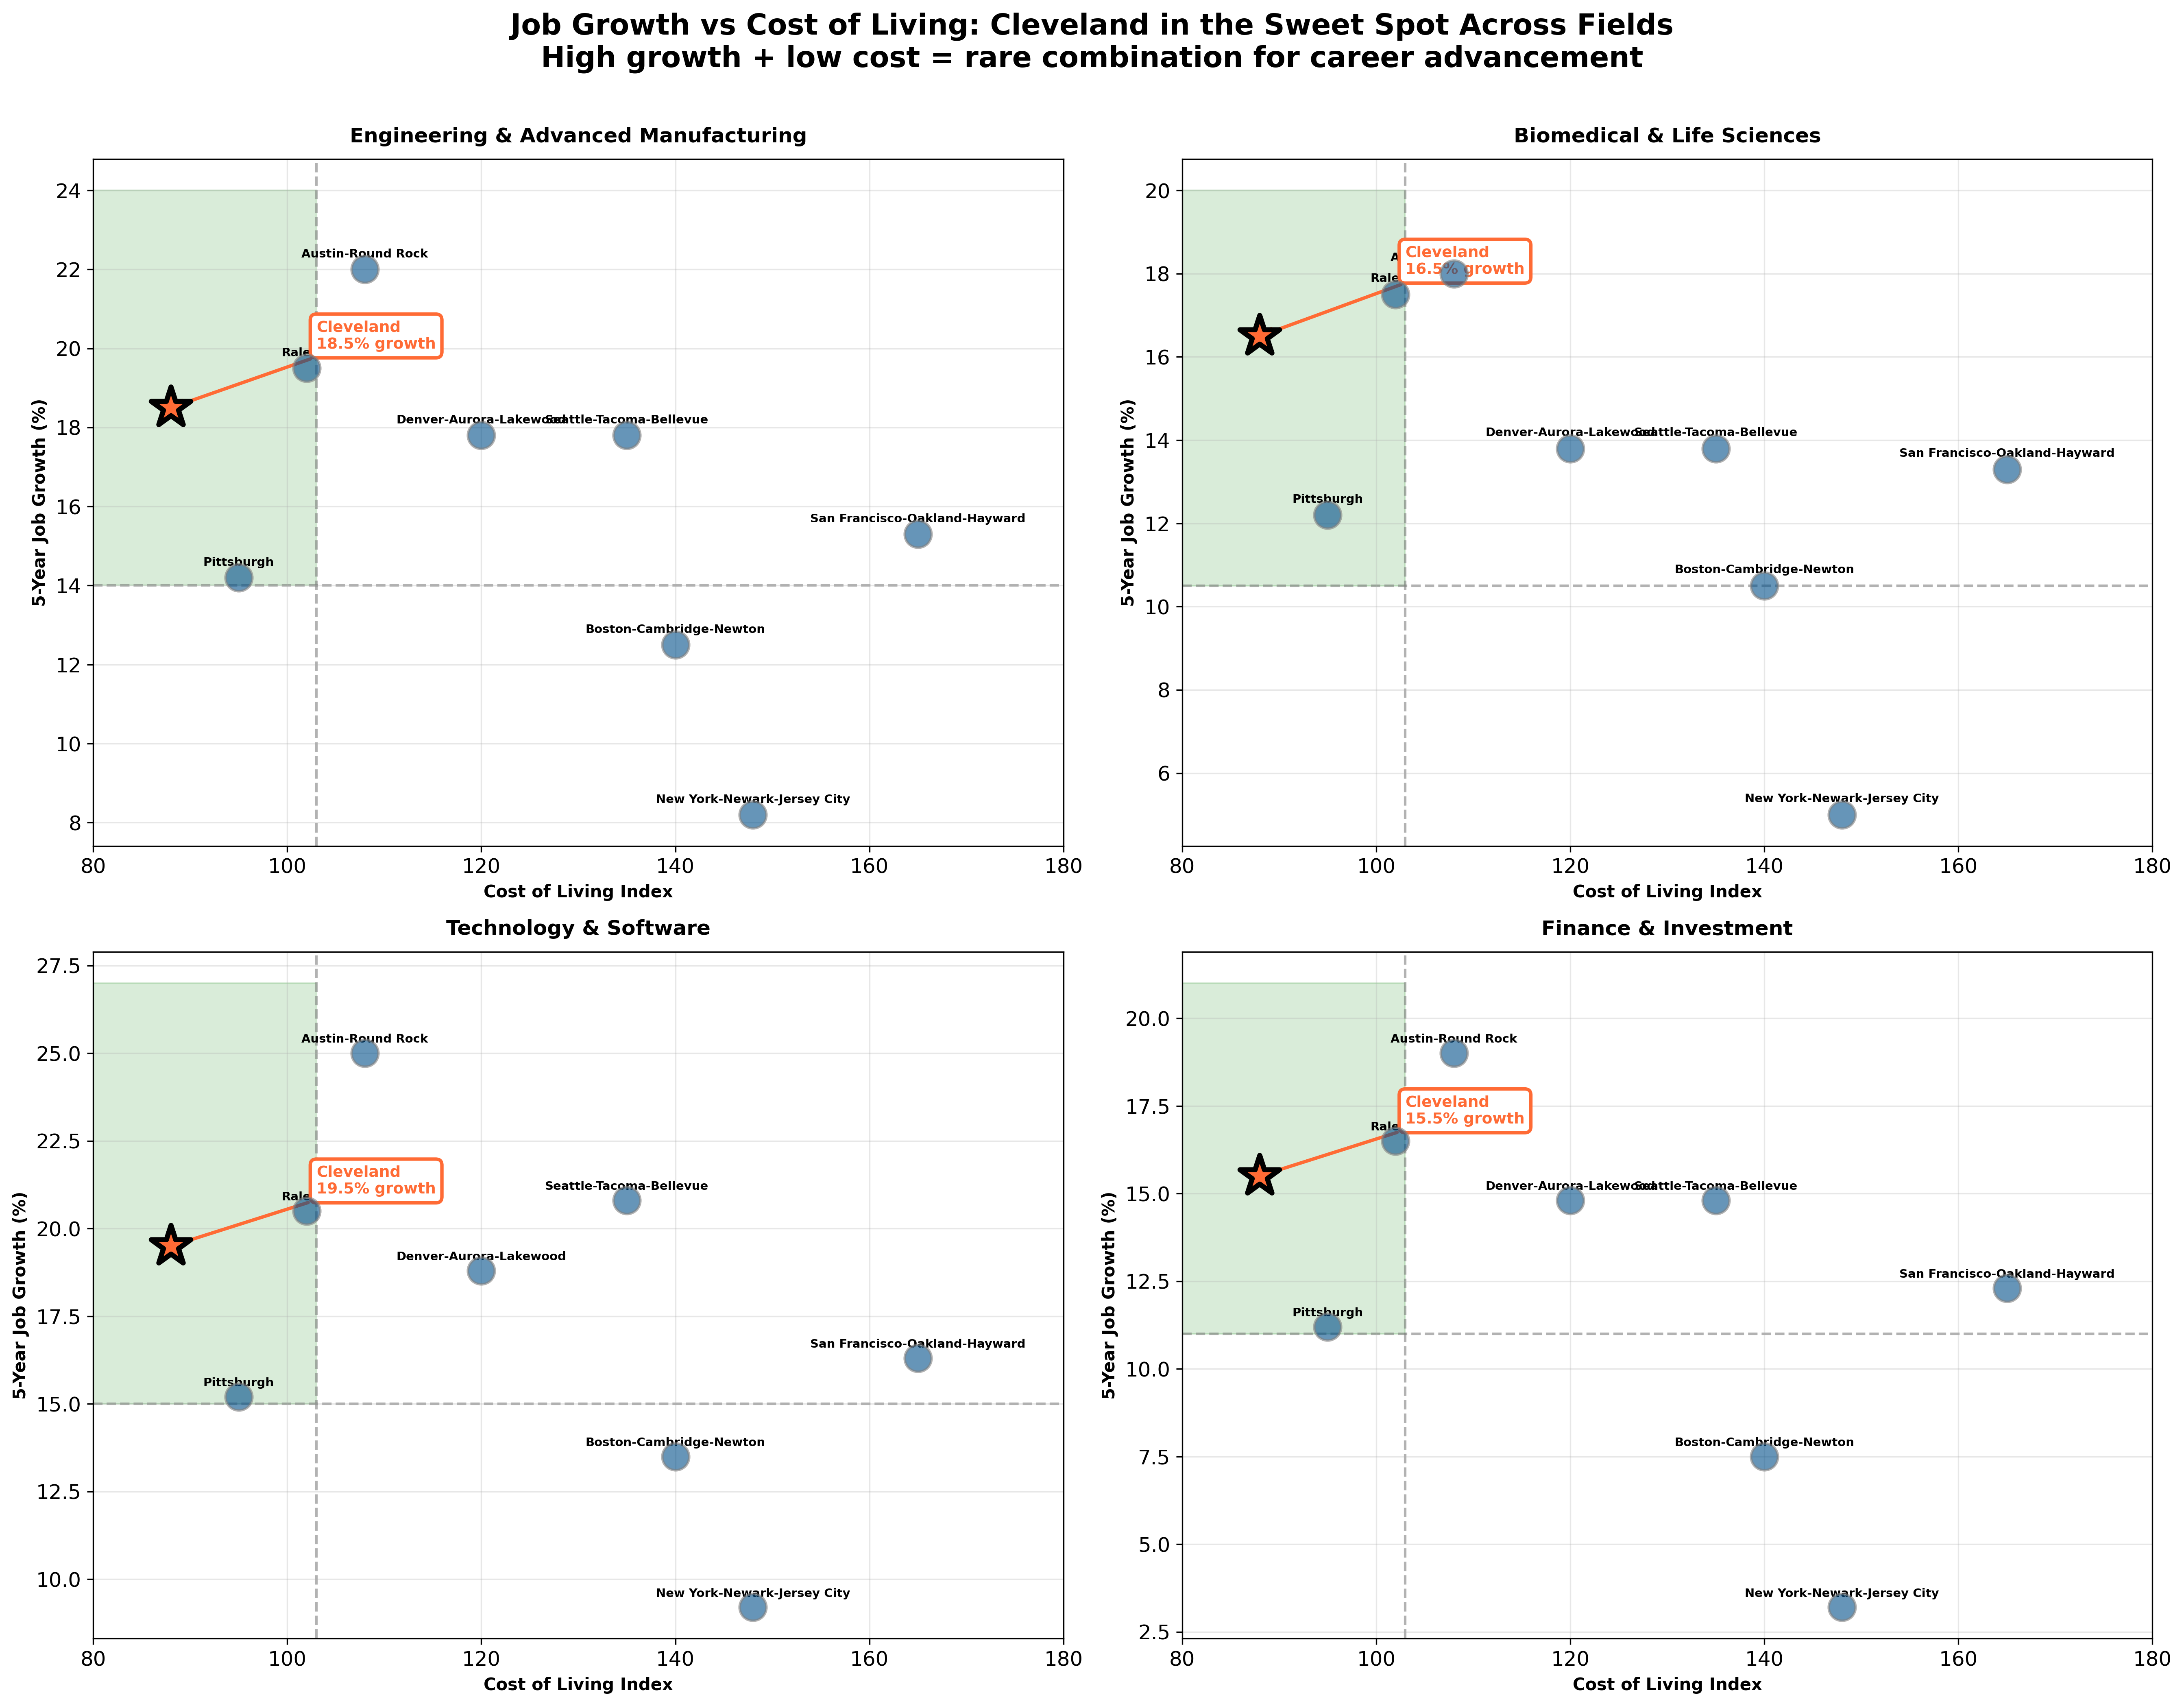

In [6]:
fig, ax = plt.subplots(figsize=(16, 10), dpi=300)

highlight_metros = ['Cleveland-Elyria, OH', 'San Francisco-Oakland-Hayward, CA', 
'Seattle-Tacoma-Bellevue, WA', 'Boston-Cambridge-Newton, MA-NH',
'Austin-Round Rock, TX', 'Pittsburgh, PA']

prof_colors = {
'Engineering': '#FF6B35',
'Biomed_Engineer': '#4ECDC4',
'Biomed_Researcher': '#95E1D3',
'Tech': '#F38181',
'Finance': '#AA96DA'
}

for prof_name, color in prof_colors.items():
    salary_col = f'{prof_name}_Salary'
    for idx, row in master_df.iterrows():
        if row['Metro'] not in highlight_metros:
            ax.scatter(row['COL_Index'], row[salary_col], 
                      s=50, c=color, alpha=0.15, edgecolors='none')

for prof_name, color in prof_colors.items():
    salary_col = f'{prof_name}_Salary'
    highlight_df = master_df[master_df['Metro'].isin(highlight_metros)]
    for idx, row in highlight_df.iterrows():
        size = 600 if 'Cleveland' in row['Metro'] else 250
        edge_width = 3 if 'Cleveland' in row['Metro'] else 1.5
        marker = '*' if 'Cleveland' in row['Metro'] else 'o'
        ax.scatter(row['COL_Index'], row[salary_col], 
                  s=size, c=color, marker=marker,
                  edgecolors='black', linewidth=edge_width, 
                  alpha=0.8, zorder=10 if 'Cleveland' in row['Metro'] else 5)

x_line = np.linspace(80, 175, 100)
for i, (prof_name, color) in enumerate(prof_colors.items()):
    avg_salary = master_df[f'{prof_name}_Salary'].mean()
    y_line = x_line * (avg_salary / 100)
    ax.plot(x_line, y_line, '--', color=color, alpha=0.3, linewidth=1.5)

cleveland_row = master_df[master_df['Metro'].str.contains('Cleveland')].iloc[0]
ax.annotate('Cleveland:\nHigh value across\nALL professions', 
           xy=(cleveland_row['COL_Index'], cleveland_row['Tech_Salary']), 
           xytext=(105, 120000),
           arrowprops=dict(arrowstyle='->', lw=3, color='#FF6B35'),
           fontsize=13, fontweight='bold', color='#FF6B35',
           bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                    edgecolor='#FF6B35', linewidth=2.5))

top_cities = {
    'Finance': [('New York-Newark-Jersey City, NY-NJ-PA', 'NYC'), 
                ('Chicago-Naperville-Elgin, IL-IN-WI', 'Chicago')],
    'Tech': [('San Francisco-Oakland-Hayward, CA', 'SF'), 
             ('Seattle-Tacoma-Bellevue, WA', 'Seattle')],
    'Biomed_Researcher': [('Boston-Cambridge-Newton, MA-NH', 'Boston')],
    'Engineering': [('Houston-The Woodlands-Sugar Land, TX', 'Houston')]
}

for field, cities in top_cities.items():
    for full_name, short_name in cities:
        city_row = master_df[master_df['Metro'] == full_name]
        if not city_row.empty:
            city_row = city_row.iloc[0]
            salary_col = f'{field}_Salary' if field != 'Engineering' else 'Engineering_Salary'
            ax.annotate(short_name, 
                       xy=(city_row['COL_Index'], city_row[salary_col]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, fontweight='bold', 
                       alpha=0.7)

ax.set_xlabel('Cost of Living Index (100 = US Average)', fontsize=14, fontweight='bold')
ax.set_ylabel('Median Annual Salary ($)', fontsize=14, fontweight='bold')
ax.set_title('Salary Efficiency Across Professions: Cleveland Delivers Value for All Career Paths\nEngineers • Biomedical Engineers • Biomedical Researchers • Tech • Finance', 
            fontsize=16, fontweight='bold', pad=20)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, markersize=12, 
                             label=prof_name.replace('_', ' '), 
                             markeredgecolor='black', markeredgewidth=1.5)
                  for prof_name, color in prof_colors.items()]
legend_elements.append(plt.Line2D([0], [0], marker='*', color='w', 
                                 markerfacecolor='#FF6B35', markersize=18, 
                                 label='Cleveland', markeredgecolor='black', markeredgewidth=2))
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, framealpha=0.95)

ax.grid(alpha=0.3)
ax.set_xlim(80, 180)
ax.set_ylim(65000, 180000)
plt.tight_layout()

fig, axes = plt.subplots(2, 2, figsize=(18, 14), dpi=300)
axes = axes.flatten()

growth_fields = {
    'Engineering': 'Job_Growth_Engineering',
    'Biomed': 'Job_Growth_Biomed',
    'Tech': 'Job_Growth_Tech',
    'Finance': 'Job_Growth_Finance'
}

field_titles = {
    'Engineering': 'Engineering & Advanced Manufacturing',
    'Biomed': 'Biomedical & Life Sciences',
    'Tech': 'Technology & Software',
    'Finance': 'Finance & Investment'
}

for idx, (field_name, growth_col) in enumerate(growth_fields.items()):
    ax = axes[idx]
    
    quadrant_metros = ['Cleveland-Elyria, OH', 'Austin-Round Rock, TX', 'Pittsburgh, PA',
                      'Raleigh, NC', 'San Francisco-Oakland-Hayward, CA', 
                      'Seattle-Tacoma-Bellevue, WA', 'Boston-Cambridge-Newton, MA-NH',
                      'New York-Newark-Jersey City, NY-NJ-PA', 'Denver-Aurora-Lakewood, CO']
    
    quad_df = master_df[master_df['Metro'].isin(quadrant_metros)]
    
    median_col = master_df['COL_Index'].median()
    median_growth = master_df[growth_col].median()
    
    ax.axhspan(median_growth, quad_df[growth_col].max() + 2, 
              xmin=0, xmax=(median_col - 80) / (180 - 80), 
              alpha=0.15, color='green', zorder=0)
    
    ax.axhline(median_growth, linestyle='--', color='gray', linewidth=1.5, alpha=0.6, zorder=1)
    ax.axvline(median_col, linestyle='--', color='gray', linewidth=1.5, alpha=0.6, zorder=1)
    
    for _, row in quad_df.iterrows():
        if 'Cleveland' in row['Metro']:
            ax.scatter(row['COL_Index'], row[growth_col], s=600, c='#FF6B35',
                      marker='*', edgecolors='black', linewidth=3, zorder=10)
        else:
            ax.scatter(row['COL_Index'], row[growth_col], s=250, c='#004E89',
                      alpha=0.6, edgecolors='gray', linewidth=1.5, zorder=5)
        
        if 'Cleveland' not in row['Metro']:
            offset_y = 0.3
            ax.text(row['COL_Index'], row[growth_col] + offset_y,
                   row['Metro'].split(',')[0], fontsize=7, ha='center', fontweight='bold')
    
    cleveland_row = quad_df[quad_df['Metro'].str.contains('Cleveland')].iloc[0]
    ax.annotate(f"Cleveland\n{cleveland_row[growth_col]:.1f}% growth", 
               xy=(cleveland_row['COL_Index'], cleveland_row[growth_col]),
               xytext=(cleveland_row['COL_Index'] + 15, cleveland_row[growth_col] + 1.5),
               arrowprops=dict(arrowstyle='->', lw=2, color='#FF6B35'),
               fontsize=9, fontweight='bold', color='#FF6B35',
               bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                        edgecolor='#FF6B35', linewidth=2))
    
    ax.set_xlabel('Cost of Living Index', fontsize=10, fontweight='bold')
    ax.set_ylabel('5-Year Job Growth (%)', fontsize=10, fontweight='bold')
    ax.set_title(field_titles[field_name], fontsize=12, fontweight='bold', pad=10)
    ax.grid(alpha=0.3, zorder=0)
    ax.set_xlim(80, 180)

fig.suptitle('Job Growth vs Cost of Living: Cleveland in the Sweet Spot Across Fields\nHigh growth + low cost = rare combination for career advancement', 
            fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.985])

## visualization 2: Cost-adjusted salary rankings

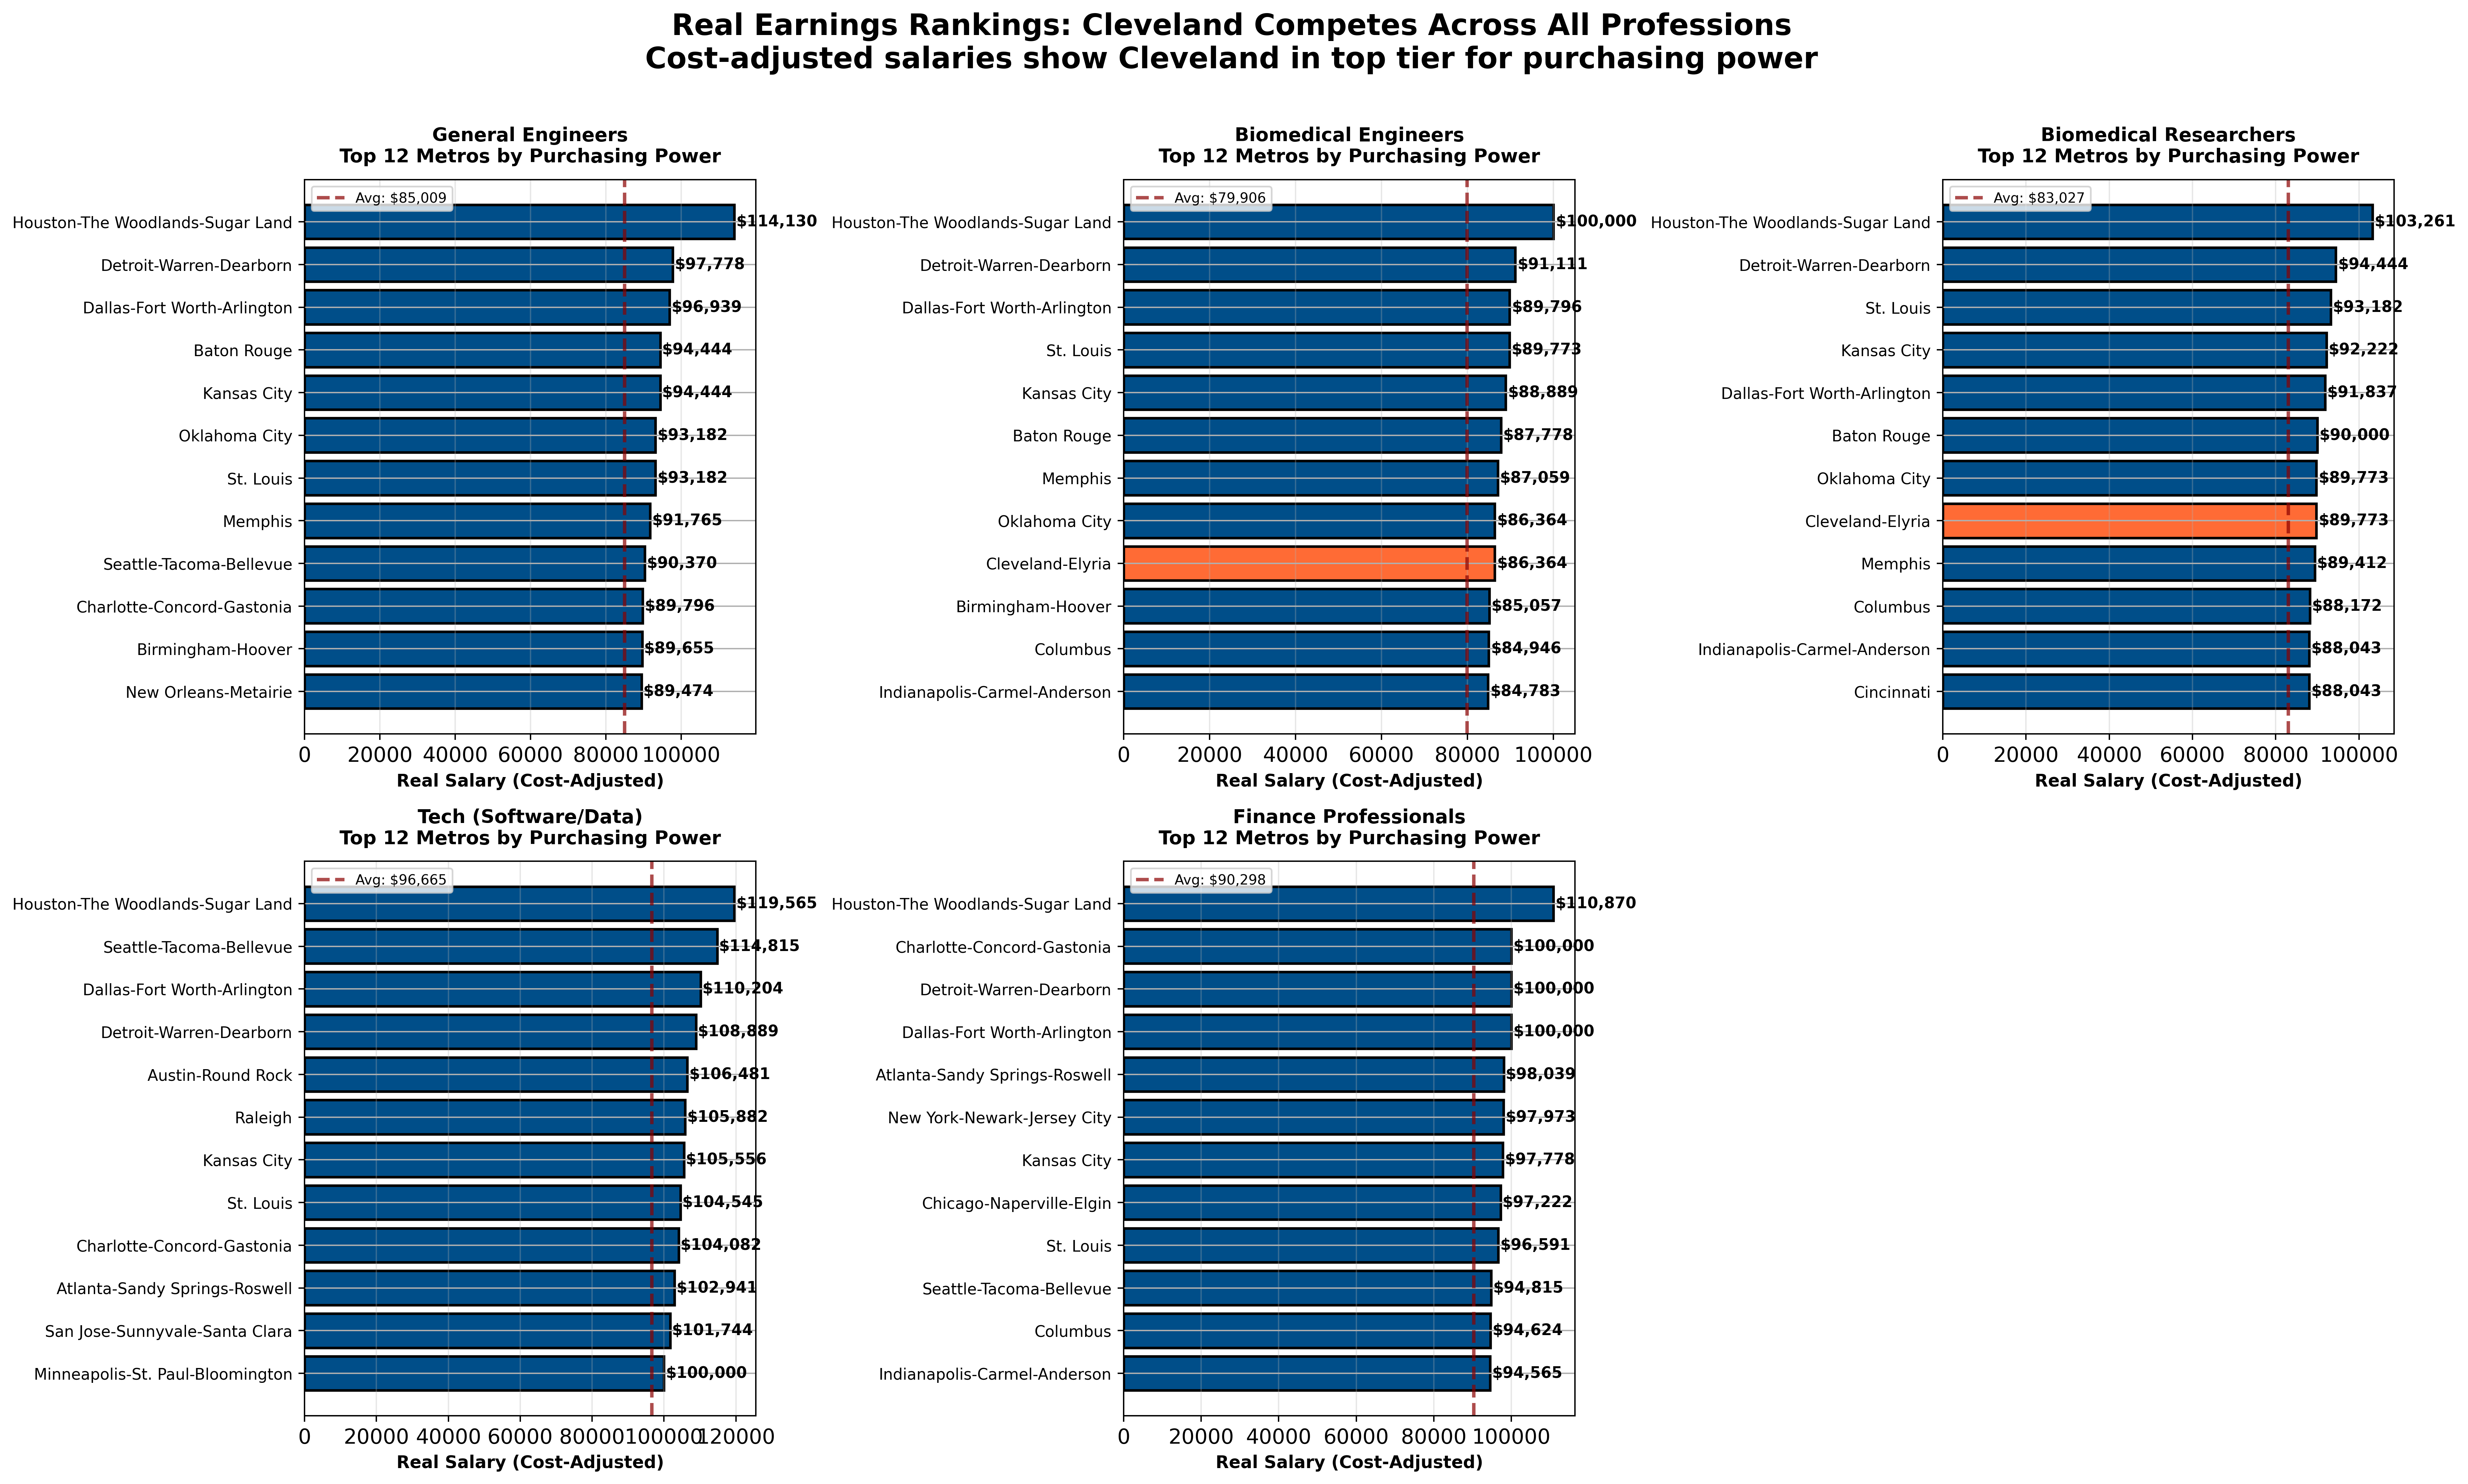

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

professions_list = ['Engineering', 'Biomed_Engineer', 'Biomed_Researcher', 'Tech', 'Finance']
prof_titles = {
    'Engineering': 'General Engineers',
    'Biomed_Engineer': 'Biomedical Engineers',
    'Biomed_Researcher': 'Biomedical Researchers',
    'Tech': 'Tech (Software/Data)',
    'Finance': 'Finance Professionals'
}

for idx, prof_name in enumerate(professions_list):
    ax = axes[idx]
    
    # Get top 12 by real salary for this profession
    top_12 = master_df.nlargest(12, f'{prof_name}_Real_Salary').sort_values(f'{prof_name}_Real_Salary')
    
    colors = ['#FF6B35' if 'Cleveland' in metro else '#004E89' for metro in top_12['Metro']]
    bars = ax.barh(range(len(top_12)), top_12[f'{prof_name}_Real_Salary'], 
                   color=colors, edgecolor='black', linewidth=1.5)
    
    # Add values
    for i, (_, row) in enumerate(top_12.iterrows()):
        ax.text(row[f'{prof_name}_Real_Salary'] + 500, i, 
                f"${row[f'{prof_name}_Real_Salary']:,.0f}", 
                va='center', fontsize=9, fontweight='bold')
    
    # City labels
    ax.set_yticks(range(len(top_12)))
    ax.set_yticklabels([m.split(',')[0] for m in top_12['Metro']], fontsize=9)
    
    # National average line
    avg_real = master_df[f'{prof_name}_Real_Salary'].mean()
    ax.axvline(avg_real, linestyle='--', color='darkred', linewidth=2, 
               alpha=0.7, label=f'Avg: ${avg_real:,.0f}')
    
    ax.set_xlabel('Real Salary (Cost-Adjusted)', fontsize=10, fontweight='bold')
    ax.set_title(f'{prof_titles[prof_name]}\nTop 12 Metros by Purchasing Power', 
                 fontsize=11, fontweight='bold', pad=10)
    ax.legend(fontsize=8)
    ax.grid(axis='x', alpha=0.3)

# Remove empty subplot
axes[-1].axis('off')

# Add overall title
fig.suptitle('Real Earnings Rankings: Cleveland Competes Across All Professions\nCost-adjusted salaries show Cleveland in top tier for purchasing power', 
             fontsize=17, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.985])

# visualization 3: housig burden comparison across different professions

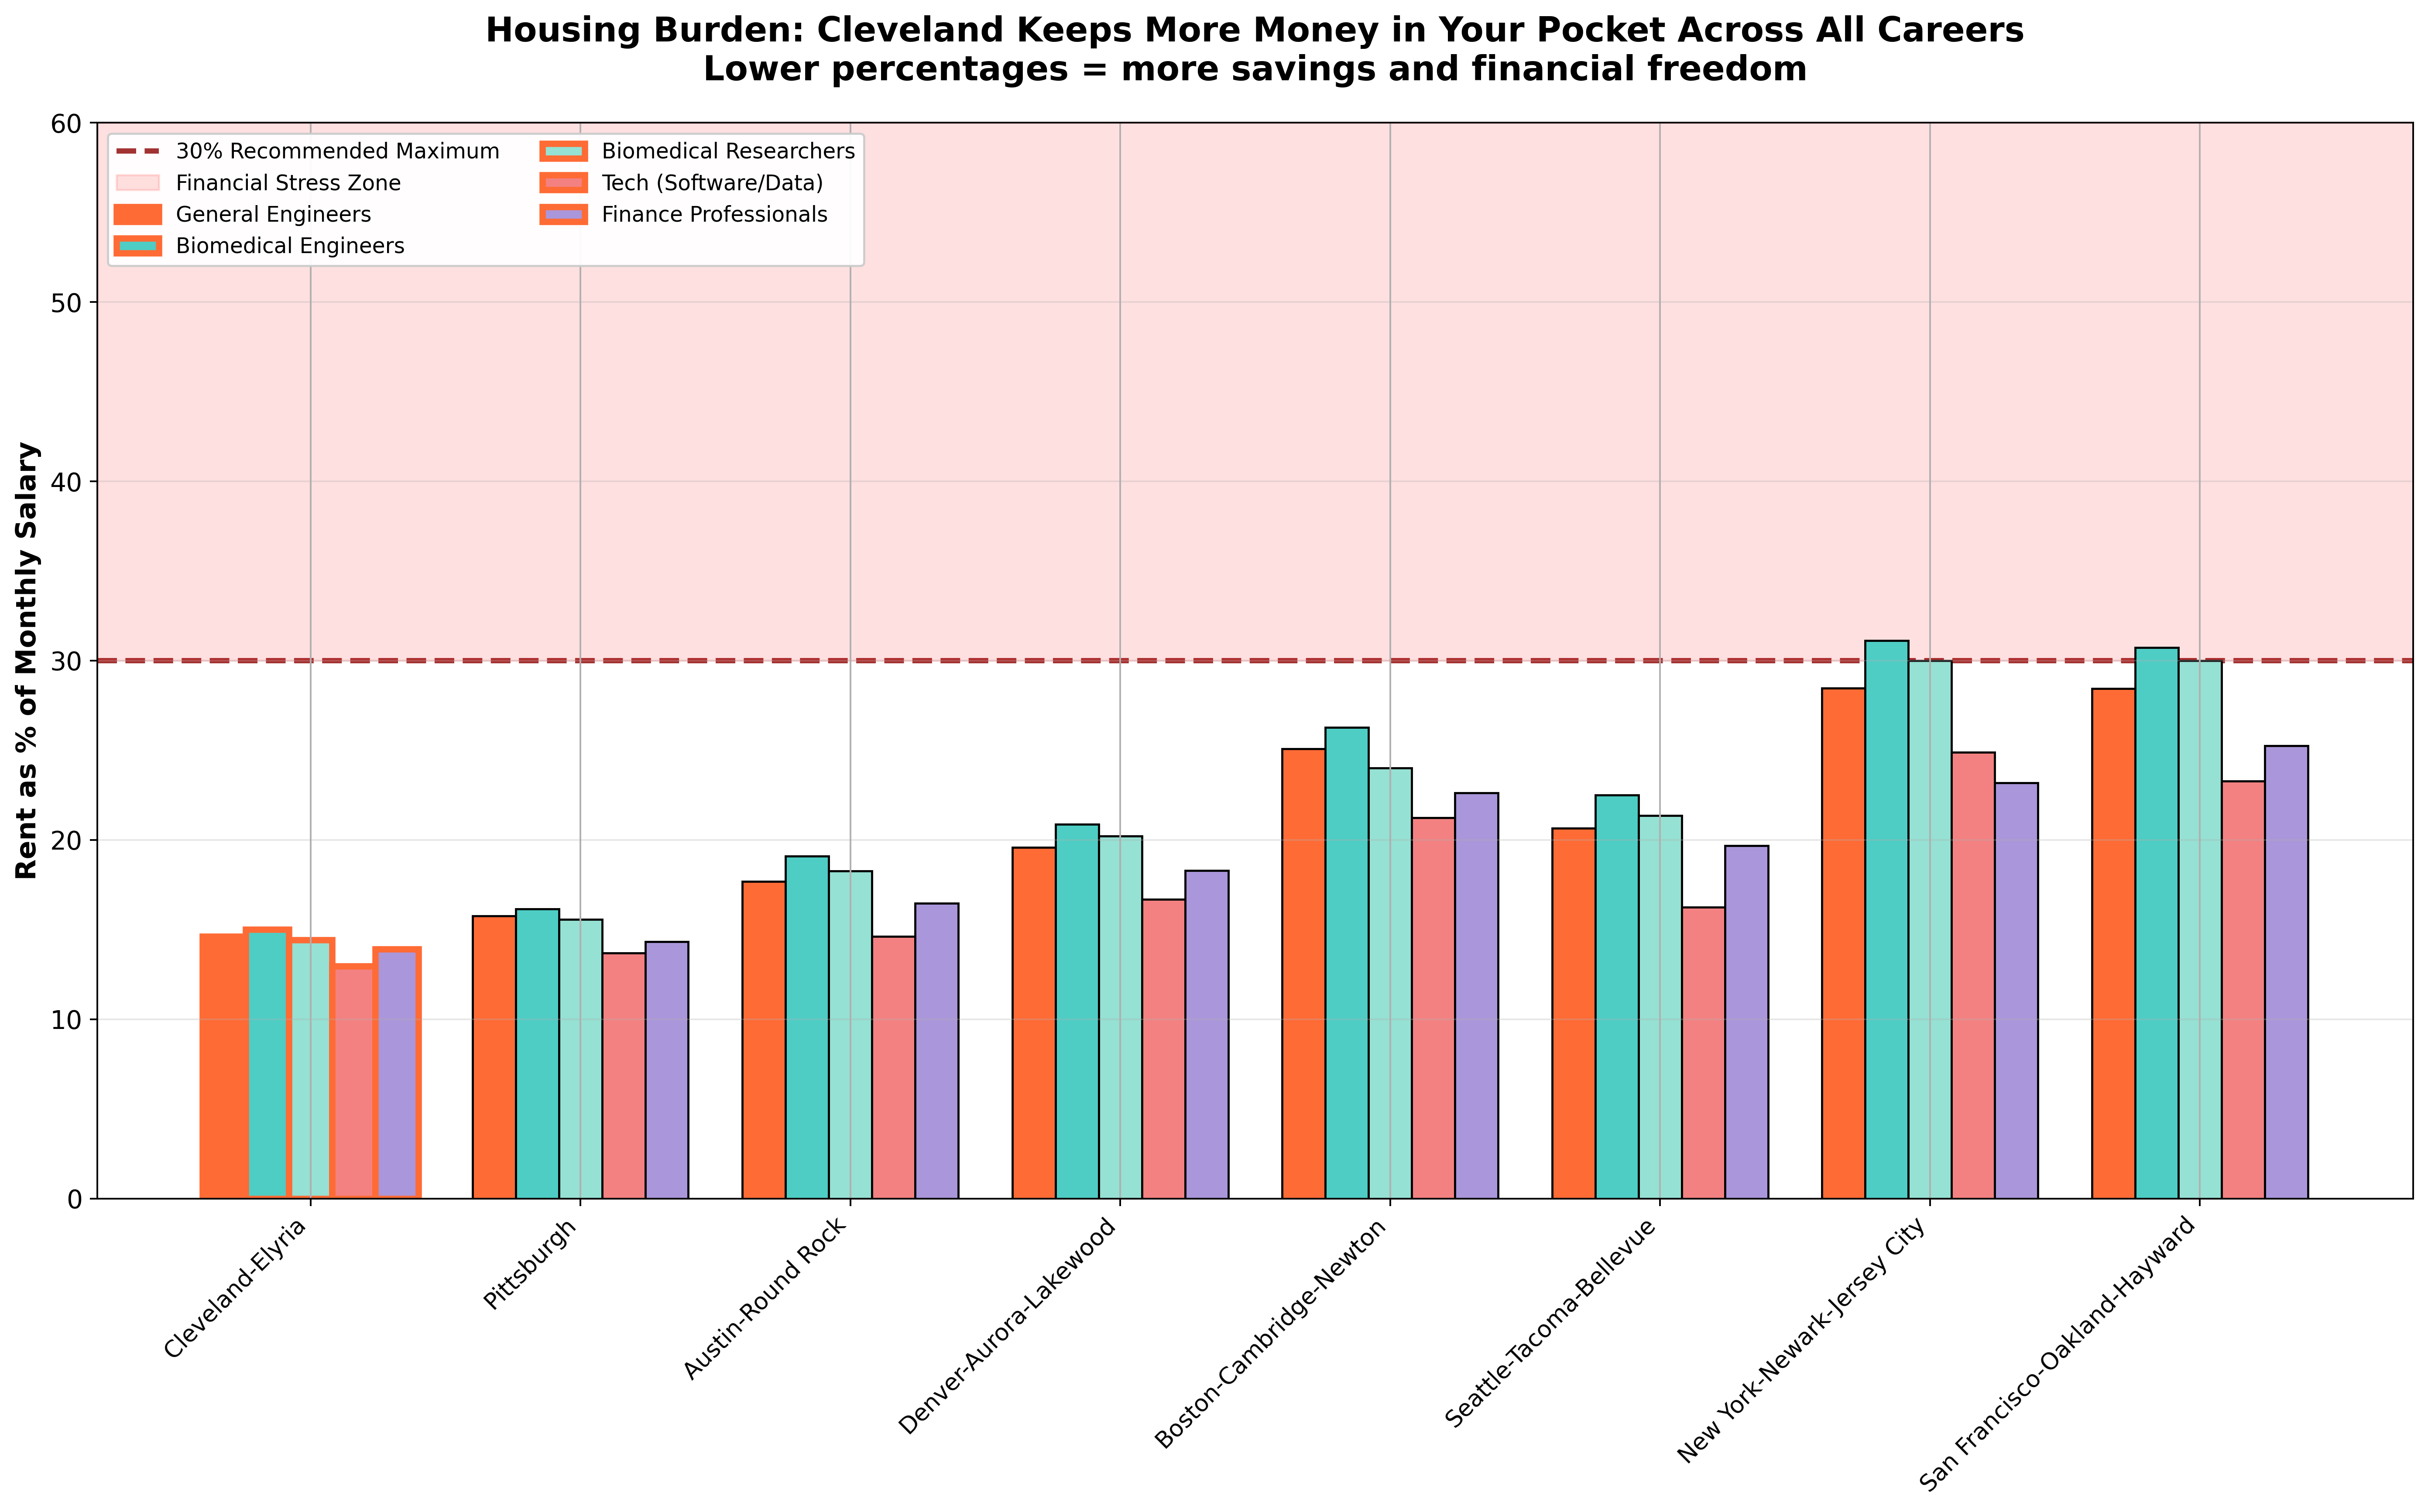

In [8]:
comparison_metros = ['Cleveland-Elyria, OH', 'Pittsburgh, PA', 'Austin-Round Rock, TX',
                     'Denver-Aurora-Lakewood, CO', 'Boston-Cambridge-Newton, MA-NH',
                     'Seattle-Tacoma-Bellevue, WA', 'New York-Newark-Jersey City, NY-NJ-PA',
                     'San Francisco-Oakland-Hayward, CA']

housing_comp = master_df[master_df['Metro'].isin(comparison_metros)]

fig, ax = plt.subplots(figsize=(16, 10))

x = np.arange(len(comparison_metros))
width = 0.16

# Plot bars for each profession
for i, prof_name in enumerate(professions_list):
    burden_col = f'{prof_name}_Housing_Burden'
    burdens = [housing_comp[housing_comp['Metro'] == m][burden_col].values[0] 
               for m in comparison_metros]
    
    offset = (i - 2) * width
    bars = ax.bar(x + offset, burdens, width, label=prof_titles[prof_name], 
                  color=prof_colors[prof_name], edgecolor='black', linewidth=1)
    
    # Highlight Cleveland bars
    cleveland_idx = comparison_metros.index('Cleveland-Elyria, OH')
    bars[cleveland_idx].set_linewidth(3)
    bars[cleveland_idx].set_edgecolor('#FF6B35')

# Benchmark line
ax.axhline(30, linestyle='--', color='darkred', linewidth=2.5, alpha=0.8, 
           label='30% Recommended Maximum', zorder=0)

# Shade stress zone
ax.axhspan(30, 60, alpha=0.12, color='red', label='Financial Stress Zone', zorder=0)

ax.set_ylabel('Rent as % of Monthly Salary', fontsize=13, fontweight='bold')
ax.set_title('Housing Burden: Cleveland Keeps More Money in Your Pocket Across All Careers\nLower percentages = more savings and financial freedom', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.split(',')[0] for m in comparison_metros], 
                    rotation=45, ha='right', fontsize=11)
ax.legend(loc='upper left', fontsize=10, ncol=2, framealpha=0.95)
ax.set_ylim(0, 60)
ax.grid(axis='y', alpha=0.3, zorder=0)

plt.tight_layout()